## Now Training Multiple Models and Comparing Performance Using PyCaret
- GitHub link: https://github.com/pycaret/pycaret
- Documentation and tutorials also found on the GitHub

In [7]:
import pycaret
# import pycaret.classification
from pycaret.classification import *
import pandas as pd
pycaret.__version__

'3.3.2'

In [8]:
# load in data 
train_data = pd.read_csv("../motum/data_for_pycaret_train.csv")
test_data = pd.read_csv("../motum/data_for_pycaret_test.csv")
print(train_data.shape)
print(test_data.shape)

# initializing pycaret setup
s = setup(
    data=train_data,
    test_data=test_data,            
    target="label",
    session_id=42,
    fold_strategy="groupkfold",     # we are doing a group-aware cross validation
    fold_groups="subject_id",     
    ignore_features=["subject_id"], # keep for grouping, not modeling
    fold=5, # number of CV folds
    index=False,
    normalize=True,
    normalize_method='zscore'
)

(51, 12)
(13, 12)


,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Target mapping,"glioma: 0, metastasis: 1"
4,Original data shape,"(64, 12)"
5,Transformed data shape,"(64, 11)"
6,Transformed train set shape,"(51, 11)"
7,Transformed test set shape,"(13, 11)"
8,Ignore features,1
9,Numeric features,10


In [9]:
# initiating classification experiment class
exp = ClassificationExperiment()
type(exp)

# initiating setup on exp
exp.setup(
    data=train_data,
    test_data=test_data,            
    target="label",
    session_id=42,
    fold_strategy="groupkfold",     # we are doing a group-aware cross validation
    fold_groups="subject_id",     
    ignore_features=["subject_id"], # keep for grouping, not modeling
    fold=5, # number of CV folds
    index=False,
    normalize=True,
    normalize_method='zscore'
)

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Target mapping,"glioma: 0, metastasis: 1"
4,Original data shape,"(64, 12)"
5,Transformed data shape,"(64, 11)"
6,Transformed train set shape,"(51, 11)"
7,Transformed test set shape,"(13, 11)"
8,Ignore features,1
9,Numeric features,10


In [10]:
# comparing these basline models now
best = compare_models(probability_threshold = 0.5, turbo=False, n_select=-1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.7455,0.7667,0.7455,0.7920,0.7313,0.4703,0.5166,0.0080
lda,Linear Discriminant Analysis,0.7455,0.7643,0.7455,0.8007,0.7384,0.4931,0.5368,0.0060
knn,K Neighbors Classifier,0.7436,0.8392,0.7436,0.7686,0.7388,0.4698,0.4946,0.0200
rbfsvm,SVM - Radial Kernel,0.7436,0.7773,0.7436,0.7827,0.7329,0.4589,0.5031,0.0080
rf,Random Forest Classifier,0.7418,0.8025,0.7418,0.7742,0.7322,0.4701,0.5003,0.0300
lightgbm,Light Gradient Boosting Machine,0.7291,0.7313,0.7291,0.7494,0.7263,0.4492,0.4671,0.0360
lr,Logistic Regression,0.7273,0.7587,0.7273,0.7445,0.7162,0.4295,0.4509,0.0160
ridge,Ridge Classifier,0.7255,0.7643,0.7255,0.7767,0.7178,0.4464,0.4885,0.0080
gpc,Gaussian Process Classifier,0.7036,0.7433,0.7036,0.7361,0.7015,0.4098,0.4308,0.0080
et,Extra Trees Classifier,0.7018,0.8133,0.7018,0.7468,0.6947,0.4004,0.4356,0.0460


In [11]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [12]:
# SGD 
sgd = create_model('svm') # actually SGD - good for larger datasets but ours is small

params_sgd = {
    'alpha': [1e-5, 0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet']
}

# tune with custom grid
tuned_sgd = tune_model(sgd, custom_grid=params_sgd, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_sgd.get_params()
print(best_params)

# for param in params_sgd.keys():
#     val = best_params[param]
#     print(f"Best {param}: {val}")

print("Best parameters:")
final_sgd_params = {param: best_params[param] for param in params_sgd.keys()}
print(final_sgd_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
sgd_results_df = pull()
sgd_mean_metrics = sgd_results_df.loc['Mean']

evaluate_model(tuned_sgd)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8667,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.7000,0.8000,0.7000,0.8125,0.6703,0.4000,0.5000
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.5833,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.9000,0.9167,0.9000,0.9143,0.8967,0.7826,0.8018
Mean,0.7455,0.7667,0.7455,0.7920,0.7313,0.4703,0.5166
Std,0.0780,0.1243,0.0780,0.0782,0.0834,0.1580,0.1543


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8667,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.5833,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7655,0.8070,0.7655,0.8034,0.7576,0.5169,0.5528
Std,0.0766,0.1547,0.0766,0.0845,0.0814,0.1681,0.1693


Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'alpha': 0.01, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.001, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Best parameters:
{'alpha': 0.01, 'penalty': 'elasticnet'}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [13]:
# RBF SVM
## ROUND 1
rbf_svm = create_model('rbfsvm')

params_rbf_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'class_weight': [None, 'balanced']
}

# tune with custom grid
tuned_rbf_svm = tune_model(rbf_svm, custom_grid=params_rbf_svm, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_rbf_svm.get_params()
print(best_params)

for param in params_rbf_svm.keys():
    val = best_params[param]
    print(f"Best {param}: {val}")

## ROUND 2
# making RBF-SVM model and tuning hyperparameters
rbf_svm2 = create_model('rbfsvm')

params_rbf_svm2 = {
    'C': [50, 75, 100, 150, 200, 500], # harsher boruta requires higher C but higher risk of overfitting
    'gamma': [0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075], # controls how tightly each training point influences the decision boundary.
    'class_weight': [None, 'balanced'],
    "max_iter": [500, 1000, 3000, 10000]
}

# tune with custom grid
tuned_rbf_svm2 = tune_model(rbf_svm2, custom_grid=params_rbf_svm2, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_rbf_svm2.get_params()
print(best_params)

# accessing specific hyperparameters
print("Best parameters:")
final_rbf_svm2_params = {param: best_params[param] for param in params_rbf_svm2.keys()}
print(final_rbf_svm2_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
rbf_svm_results_df = pull()
rbf_svm_mean_metrics = rbf_svm_results_df.loc['Mean']

evaluate_model(tuned_rbf_svm2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8000,0.8182,0.8636,0.8084,0.6207,0.6708
1,0.8000,0.9200,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.8000,0.7917,0.8000,0.8500,0.7810,0.5455,0.6124
3,0.4000,0.3750,0.4000,0.4000,0.4000,-0.2500,-0.2500
4,0.8000,1.0000,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7236,0.7773,0.7236,0.7675,0.7162,0.4263,0.4709
Std,0.1620,0.2157,0.1620,0.1838,0.1584,0.3392,0.3610


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7667,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.8000,0.9200,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.9000,0.9583,0.9000,0.9200,0.9010,0.8000,0.8165
Mean,0.7455,0.7790,0.7455,0.7781,0.7307,0.4624,0.4996
Std,0.1004,0.1436,0.1004,0.1205,0.1124,0.2352,0.2413


Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best C: 100
Best gamma: 0.001
Best class_weight: None


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8000,0.8182,0.8636,0.8084,0.6207,0.6708
1,0.8000,0.9200,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.8000,0.7917,0.8000,0.8500,0.7810,0.5455,0.6124
3,0.4000,0.3750,0.4000,0.4000,0.4000,-0.2500,-0.2500
4,0.8000,1.0000,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7236,0.7773,0.7236,0.7675,0.7162,0.4263,0.4709
Std,0.1620,0.2157,0.1620,0.1838,0.1584,0.3392,0.3610


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.9000,0.9583,0.9000,0.9143,0.8967,0.7826,0.8018
Mean,0.7655,0.8003,0.7655,0.7888,0.7513,0.4989,0.5290
Std,0.1177,0.1526,0.1177,0.1292,0.1298,0.2659,0.2661


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 75, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.00075, 'kernel': 'rbf', 'max_iter': 500, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best parameters:
{'C': 75, 'gamma': 0.00075, 'class_weight': None, 'max_iter': 500}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [14]:
from sklearn.svm import SVC
svm_linear = create_model(SVC(kernel="linear", probability=True))
params_svml = {
    "C": [0.01, 0.1, 1, 10, 100],# reg param
    # "penalty": ["l2", "l1"] # l2 is standard for cvm according to sklearn
}

tuned_svm_linear = tune_model(svm_linear, custom_grid=params_svml, n_iter=100)
best_params = tuned_svm_linear.get_params()
print(best_params)

print("Best parameters:")
final_svml_params = {param: best_params[param] for param in params_svml.keys()}
print(final_svml_params)

evaluate_model(tuned_svm_linear)

# save the mean accuracy, AUC, recall, precision, and F1 score
svml_results_df = pull()
svml_mean_metrics = svml_results_df.loc['Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.7000,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.8000,0.9600,0.8000,0.8571,0.7917,0.6000,0.6547
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7073,0.7737,0.7073,0.7325,0.6947,0.3895,0.4185
Std,0.0822,0.1562,0.0822,0.1152,0.0941,0.2032,0.2202


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.9200,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6667,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.9000,0.9583,0.9000,0.9143,0.8967,0.7826,0.8018
Mean,0.7655,0.7923,0.7655,0.7888,0.7513,0.4989,0.5290
Std,0.1177,0.1449,0.1177,0.1292,0.1298,0.2659,0.2661


Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Best parameters:
{'C': 0.1}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [15]:
# Linear discriminant analysis
lda = create_model('lda')

params_lda = {
    "solver": ["svd", "lsqr", "eigen"],
    "shrinkage": [None, "auto", 0.0, 0.1, 0.2, 0.3, 0.5]  # only used for lsqr/eigen
}

# tune with custom grid
tuned_lda = tune_model(lda, custom_grid=params_lda, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_lda.get_params()
print(best_params)

print("Best parameters:")
final_lda_params = {param: best_params[param] for param in params_lda.keys()}
print(final_lda_params)

evaluate_model(tuned_lda)

# save the mean accuracy, AUC, recall, precision, and F1 score
lda_results_df = pull()
lda_mean_metrics = lda_results_df.loc['Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.8800,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
4,0.7000,0.9583,0.7000,0.8286,0.6909,0.4444,0.5345
Mean,0.7455,0.7643,0.7455,0.8007,0.7384,0.4931,0.5368
Std,0.0780,0.1348,0.0780,0.0742,0.0804,0.1543,0.1495


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7333,0.7273,0.8182,0.6961,0.4211,0.5164
1,0.9000,0.8800,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
4,0.7000,0.9583,0.7000,0.8286,0.6909,0.4444,0.5345
Mean,0.7455,0.7643,0.7455,0.8007,0.7384,0.4931,0.5368
Std,0.0780,0.1348,0.0780,0.0742,0.0804,0.1543,0.1495


Fitting 5 folds for each of 21 candidates, totalling 105 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
Best parameters:
{'solver': 'svd', 'shrinkage': None}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [16]:
# KNN
# making RBF-SVM model and tuning hyperparameters
knn = create_model('knn')

params_knn = {
    "n_neighbors": [5, 7, 9, 11, 15, 21, 31],
    "weights": ["distance", "uniform"],
    "metric": ["manhattan", "euclidean"],
    "p": [1, 2]
}

# tune with custom grid
tuned_knn = tune_model(knn, custom_grid=params_knn, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_knn.get_params()
print(best_params)

print("Best parameters:")
final_knn_params = {param: best_params[param] for param in params_knn.keys()}
print(final_knn_params)

evaluate_model(tuned_knn)

# save the mean accuracy, AUC, recall, precision, and F1 score
knn_results_df = pull()
knn_mean_metrics = knn_results_df.loc['Mean']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.9000,0.8182,0.8636,0.8084,0.6207,0.6708
1,0.9000,0.9000,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.8333,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.5000,0.6042,0.5000,0.4762,0.4835,-0.0870,-0.0891
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7436,0.8392,0.7436,0.7686,0.7388,0.4698,0.4946
Std,0.1374,0.1240,0.1374,0.1603,0.1419,0.3059,0.3201


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.9333,0.9091,0.9221,0.9075,0.8136,0.8281
1,0.9000,0.8400,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.8000,0.7917,0.8000,0.8000,0.8000,0.5833,0.5833
3,0.6000,0.5833,0.6000,0.5750,0.5619,0.0909,0.1021
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.8018,0.8213,0.8018,0.8161,0.7937,0.5806,0.5993
Std,0.1113,0.1336,0.1113,0.1283,0.1248,0.2621,0.2652


Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best parameters:
{'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 1}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Other models used in literature

In [17]:
## ROUND 1
# making lasso model and tuning hyperparameters
lasso_clf = create_model('lr', penalty='l1', solver='liblinear')

# Define custom grid for L1 logistic regression hyperparameters
params_lasso = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Inverse regularization strength
    "max_iter": [1000, 3000, 5000],  # Maximum iterations
    "class_weight": [None, 'balanced']
}

# Or use random search with n_iter
tuned_lasso_clf = tune_model(lasso_clf, custom_grid=params_lasso, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_lasso_clf.get_params()
print(best_params)

for param in params_lasso.keys():
    val = best_params[param]
    print(f"Best {param}: {val}")

## ROUND 2
# making lasso model and tuning hyperparameters
lasso_clf2 = create_model('lr', penalty='l1', solver='liblinear')

# using more granular hyperparameters
params_lasso = {
    "C": [0.4, 0.6, 0.8, 1, 3, 5, 7],     # Inverse regularization strength
    "max_iter": [1000, 3000, 5000],          # Maximum iterations
    "class_weight": [None, 'balanced']
}

# Or use random search with n_iter
tuned_lasso_clf2 = tune_model(lasso_clf2, custom_grid=params_lasso, n_iter=100)

# get all hyperparameters of the best model
best_params2 = tuned_lasso_clf2.get_params()
print(best_params2)

print("Best parameters:")
final_lasso_params = {param: best_params[param] for param in params_lasso.keys()}
print(final_lasso_params)

# save the mean accuracy, AUC, recall, precision, and F1 score
lasso_results_df = pull()
lasso_mean_metrics = lasso_results_df.loc['Mean']
evaluate_model(tuned_lasso_clf2)


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:14:27
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.8667,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.9000,0.9200,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.5833,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7273,0.7657,0.7273,0.7495,0.7238,0.4447,0.4638
Std,0.1098,0.1871,0.1098,0.1233,0.1129,0.2350,0.2442


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8000,0.7273,0.7305,0.7226,0.4407,0.4485
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.8000,0.6250,0.8000,0.8000,0.8000,0.5833,0.5833
4,0.8000,0.9167,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7855,0.7853,0.7855,0.8068,0.7849,0.5679,0.5847
Std,0.0696,0.1410,0.0696,0.0762,0.0694,0.1419,0.1484


Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best C: 10
Best max_iter: 1000
Best class_weight: balanced


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.8667,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.9000,0.9200,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.5833,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
4,0.8000,0.9583,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7273,0.7657,0.7273,0.7495,0.7238,0.4447,0.4638
Std,0.1098,0.1871,0.1098,0.1233,0.1129,0.2350,0.2442


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6364,0.8000,0.6364,0.6439,0.6169,0.2414,0.2609
1,0.9000,0.9600,0.9000,0.9167,0.8990,0.8000,0.8165
2,0.7000,0.6250,0.7000,0.7200,0.7030,0.4000,0.4082
3,0.7000,0.5833,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.8000,0.9167,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7473,0.7770,0.7473,0.7685,0.7418,0.4809,0.5017
Std,0.0926,0.1511,0.0926,0.1047,0.0979,0.2008,0.2070


Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'C': 5, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best parameters:
{'C': 10, 'max_iter': 1000, 'class_weight': 'balanced'}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [18]:
## Ada just for comparison
ada_clf = create_model('ada')

ada_params = {
    "n_estimators": [30, 50, 100, 150, 200],
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
}

# tuning the model
tuned_ada_clf = tune_model(ada_clf, custom_grid=ada_params, n_iter=100)

# get all hyperparameters of the best model
best_params = tuned_ada_clf.get_params()
print(best_params)

# accessing specific hyperparameters
print("Best parameters:")
final_ada_params = {param: best_params[param] for param in ada_params.keys()}
print(final_ada_params)

# print(f"Best n_estimators: {tuned_ada_clf.get_params()['n_estimators']}")
# # no of boosting rounds; too low -> underfit; too high -> overfit

# print(f"Best learning_rate: {tuned_ada_clf.get_params()['learning_rate']}")
# # Shrinks the contribution of each weak learner
# # low LR -> need more estimators, more stability
# # higher LR -> quicker fit, risk overfitting

# save the mean accuracy, AUC, recall, precision, and F1 score
ada_results_df = pull()
ada_mean_metrics = ada_results_df.loc['Mean']
evaluate_model(tuned_ada_clf)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:14:28
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.7333,0.7273,0.7394,0.7273,0.4590,0.4667
1,0.5000,0.6200,0.5000,0.5000,0.4505,0.0000,0.0000
2,0.6000,0.8333,0.6000,0.6500,0.6000,0.2308,0.2500
3,0.7000,0.9167,0.7000,0.6952,0.6901,0.3478,0.3563
4,0.8000,0.7500,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.6655,0.7707,0.6655,0.6903,0.6536,0.3306,0.3479
Std,0.1047,0.0998,0.1047,0.1195,0.1202,0.2084,0.2220


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8000,0.8182,0.8182,0.8182,0.6333,0.6333
1,0.6000,0.7000,0.6000,0.6190,0.5833,0.2000,0.2182
2,0.7000,0.7917,0.7000,0.8286,0.6909,0.4444,0.5345
3,0.8000,0.9167,0.8000,0.8500,0.7810,0.5455,0.6124
4,0.8000,0.8750,0.8000,0.8667,0.8000,0.6154,0.6667
Mean,0.7436,0.8167,0.7436,0.7965,0.7347,0.4877,0.5330
Std,0.0830,0.0747,0.0830,0.0903,0.0874,0.1584,0.1633


Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 0.5, 'n_estimators': 30, 'random_state': 42}
Best parameters:
{'n_estimators': 30, 'learning_rate': 0.5}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Now improving ease of comparison of models with each other

In [19]:
# Comparing accuracy, AUC, recall, precision, and F1 score between the three optimized models based on k-fold cross validation
comparison_df = pd.DataFrame([
    sgd_mean_metrics,
    rbf_svm_mean_metrics,
    svml_mean_metrics,
    lda_mean_metrics,
    knn_mean_metrics,
    lasso_mean_metrics,
    ada_mean_metrics
], index=['SGD', 'RBF SVM', 'SVM Linear', 'LDA', 'KNN', 'LASSO','ADA'])

# Selecting for accruacy, AUC, recall, precision, and F1 score and printing result for ease of comparison
metrics = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1']
print(comparison_df[metrics])

            Accuracy     AUC  Recall   Prec.      F1
SGD           0.7655  0.8070  0.7655  0.8034  0.7576
RBF SVM       0.7655  0.8003  0.7655  0.7888  0.7513
SVM Linear    0.7655  0.7923  0.7655  0.7888  0.7513
LDA           0.7455  0.7643  0.7455  0.8007  0.7384
KNN           0.8018  0.8213  0.8018  0.8161  0.7937
LASSO         0.7473  0.7770  0.7473  0.7685  0.7418
ADA           0.7436  0.8167  0.7436  0.7965  0.7347


#### Choosing the extra trees model to train on the entire training dataset, and then run on test data (old).

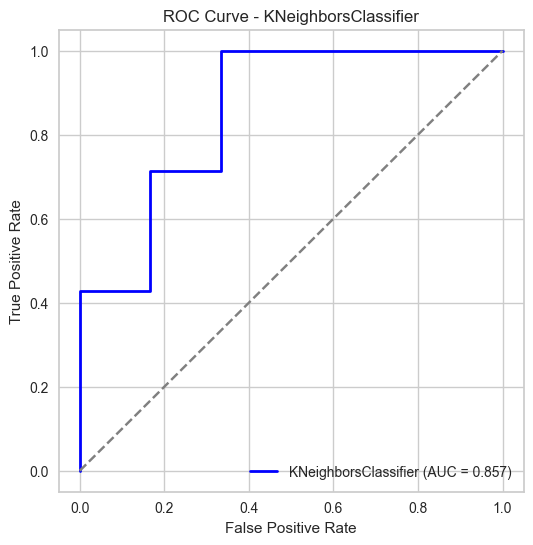

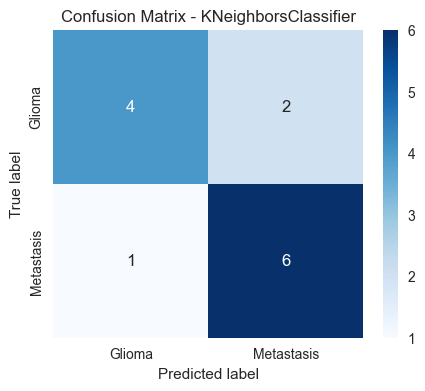

KNeighborsClassifier
Accuracy:  0.769
AUC:      0.857
Precision: 0.750
Recall:    0.857
F1 score:  0.800


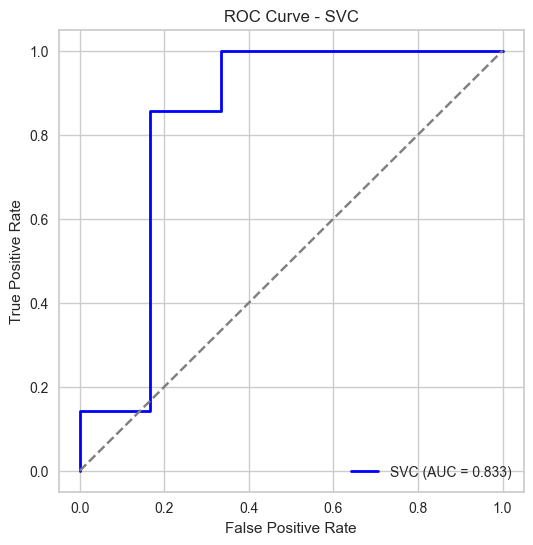

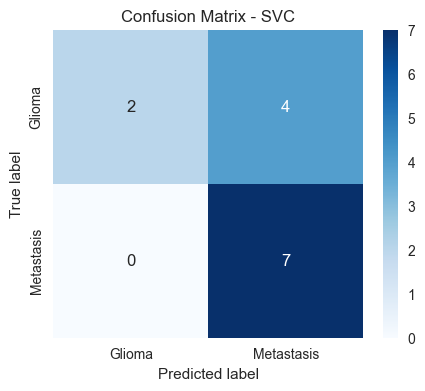

SVC
Accuracy:  0.692
AUC:      0.833
Precision: 0.636
Recall:    1.000
F1 score:  0.778


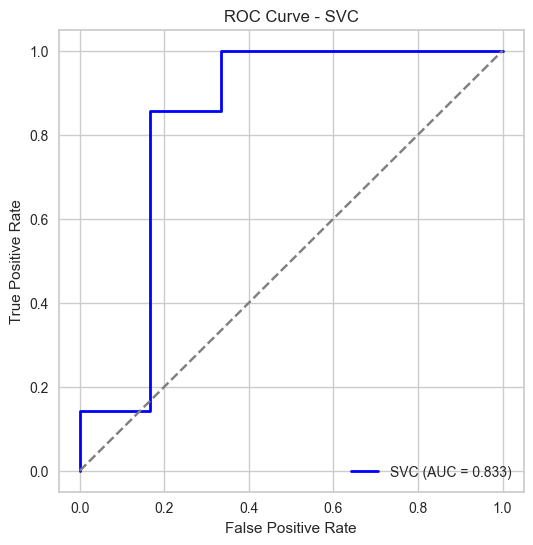

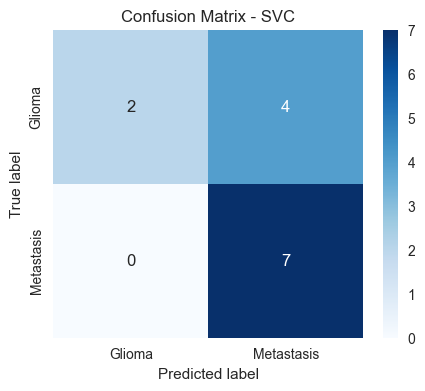

SVC
Accuracy:  0.692
AUC:      0.833
Precision: 0.636
Recall:    1.000
F1 score:  0.778


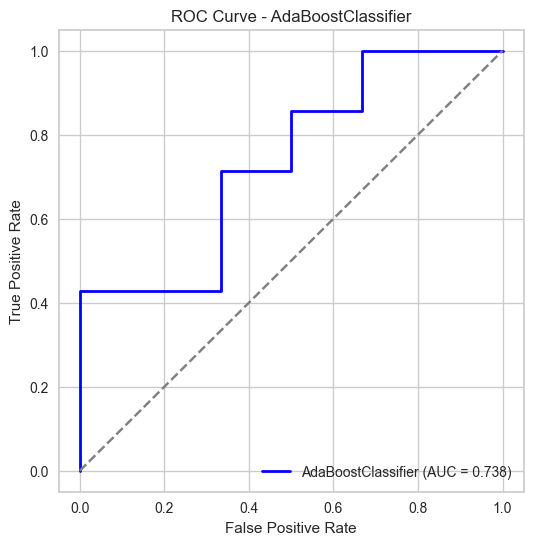

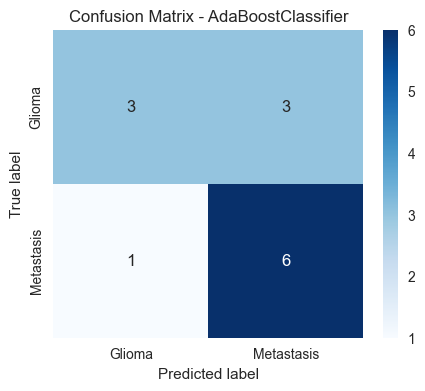

AdaBoostClassifier
Accuracy:  0.692
AUC:      0.738
Precision: 0.667
Recall:    0.857
F1 score:  0.750


In [20]:
# train classifiers on full dataset with best params
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import learning_curve, GroupKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## KNN
final_knn = KNeighborsClassifier(**final_knn_params)

# ## SGD
# final_sgd = SGDClassifier(**final_sgd_params, random_state=42)

## TRUE LINEAR SVM
final_svml = SVC(kernel='linear', **final_svml_params, random_state=42, probability=True)

## ADA
final_ada = AdaBoostClassifier(**final_ada_params, random_state=42)

# ## RBF SVM
final_svm = SVC(kernel='rbf', **final_rbf_svm2_params, random_state=42, probability=True)

# preparing X_train, X_test, y_train, and y_test, train_data and test_data were defined earlier in this notebook
# first removing subject_id column, not useful feature
train_data_noid = train_data.drop(columns=['subject_id'])
test_data_noid = test_data.drop(columns=['subject_id'])

# assign target variable to y and remove from X
X_train = train_data_noid.drop(columns=['label'])
y_train = train_data_noid['label']

X_test = test_data_noid.drop(columns=['label'])
y_test = test_data_noid['label']

# convert y_test and y_train to numeric (glioma: 0, metastasis: 1)
label_map = {'glioma': 0, 'metastasis': 1}
y_train = y_train.map(label_map)
y_test = y_test.map(label_map)

# perform z-score standardization only on X, though this is most likely unnecessary for decision trees
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # creating a learning curve to evaluate whether this model is overfitting/underfitting
# group_kfold = GroupKFold(n_splits=5)
# groups = train_data['subject_id']
# train_sizes, train_scores, val_scores = learning_curve(
#     final_svm_model,                   
#     X_train_scaled, y_train,        
#     cv=group_kfold,   
#     groups=groups,         
#     scoring='accuracy',             
#     n_jobs=-1,              
#     train_sizes=np.linspace(0.2, 1.0, 5) 
# )

# # plotting the learning curve
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# val_scores_mean = np.mean(val_scores, axis=1)
# val_scores_std = np.std(val_scores, axis=1)

# plt.figure(figsize=(8,6))
# plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
# plt.plot(train_sizes, val_scores_mean, 's-', label="Group KFold CV score")
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2)
# plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
#                  val_scores_mean + val_scores_std, alpha=0.2)
# plt.xlabel("Number of training samples")
# plt.ylabel("Accuracy")
# plt.title("Learning Curve (GroupKFold CV) - SVM (Sklearn)")
# plt.legend()
# plt.tight_layout()
# plt.show()

## train models on the entire training set
def plot_pred(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # get model name
    model_type = type(model)
    model_name = model_type.__name__

    # get test performance
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # plot ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Glioma', 'Metastasis'],
                yticklabels=['Glioma', 'Metastasis'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(model_name)
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"AUC:      {roc_auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 score:  {f1:.3f}")


plot_pred(final_knn, X_train_scaled, X_test_scaled, y_train, y_test)
plot_pred(final_svm, X_train_scaled, X_test_scaled, y_train, y_test)
plot_pred(final_svml, X_train_scaled, X_test_scaled, y_train, y_test)
plot_pred(final_ada, X_train_scaled, X_test_scaled, y_train, y_test)
# plot_pred(final_sgd, X_train_scaled, X_test_scaled, y_train, y_test)


In [21]:
coefs = final_svml.coef_.ravel()

importance = pd.Series(np.abs(coefs), index=X_train.columns).sort_values(ascending=False)
print(importance)

shape_Flatness_flair                            0.511476
firstorder_Kurtosis_flair                       0.457769
gldm_DependenceNonUniformityNormalized_flair    0.333529
gldm_DependenceVariance_t1                      0.304301
glcm_InverseVariance_flair                      0.271116
ngtdm_Strength_t2                               0.157301
firstorder_Maximum_t1                           0.116886
firstorder_Skewness_flair                       0.115015
gldm_DependenceVariance_flair                   0.070434
shape_Maximum2DDiameterRow_flair                0.053921
dtype: float64


Permutation importance for KNeighborsClassifier
Permutation importance for SVC


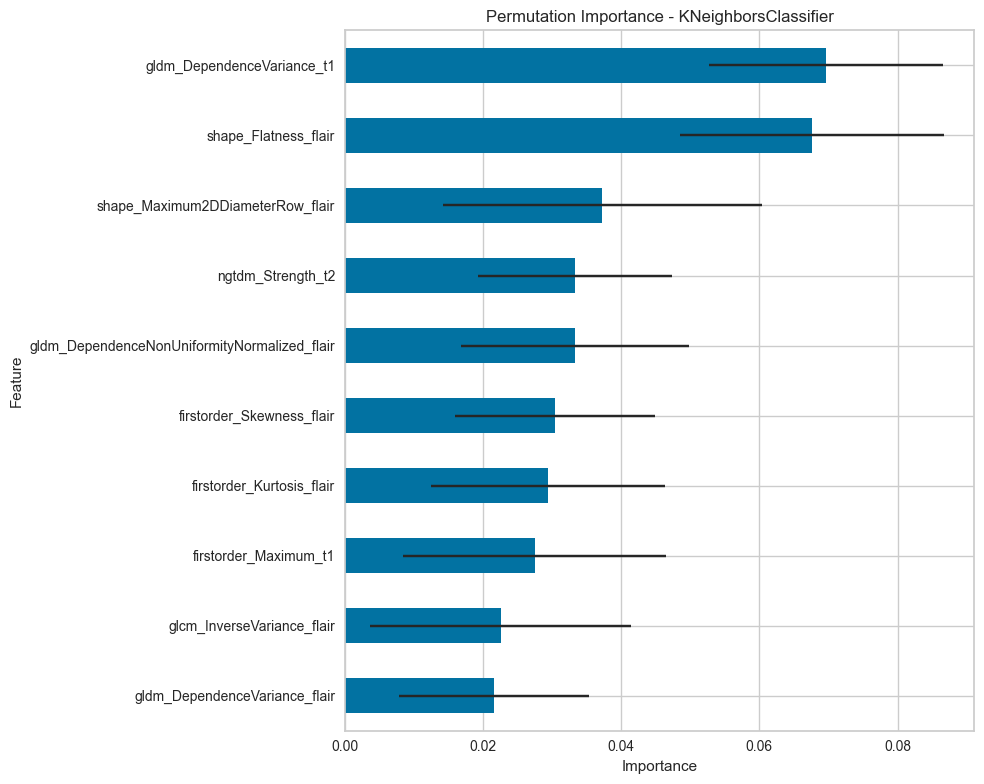

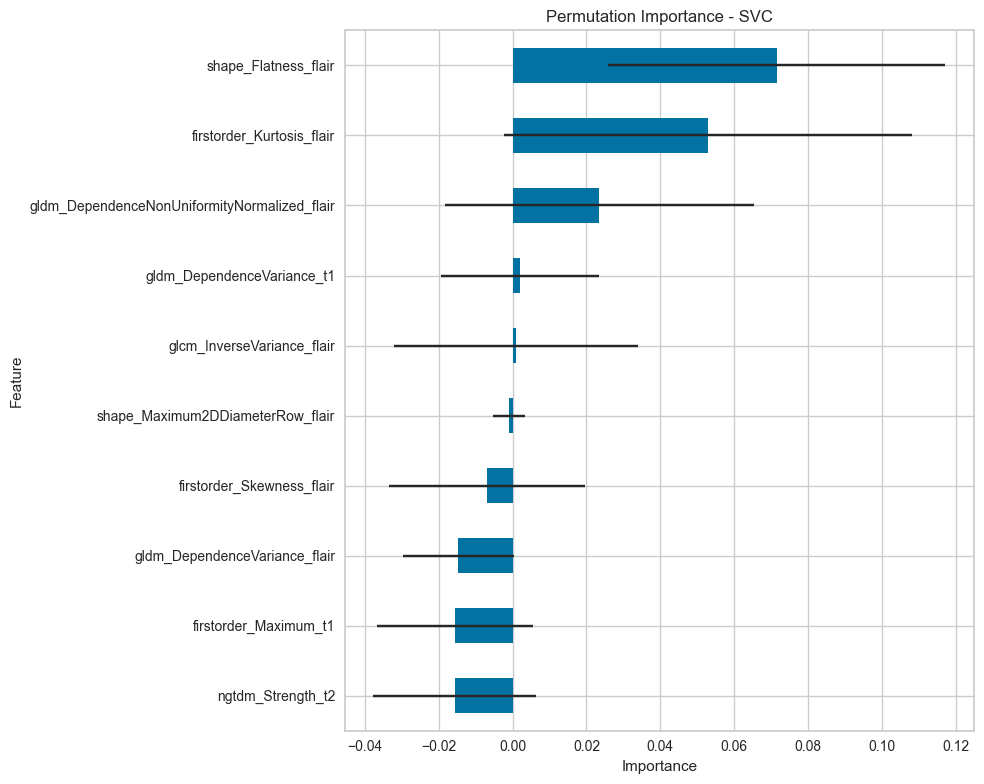

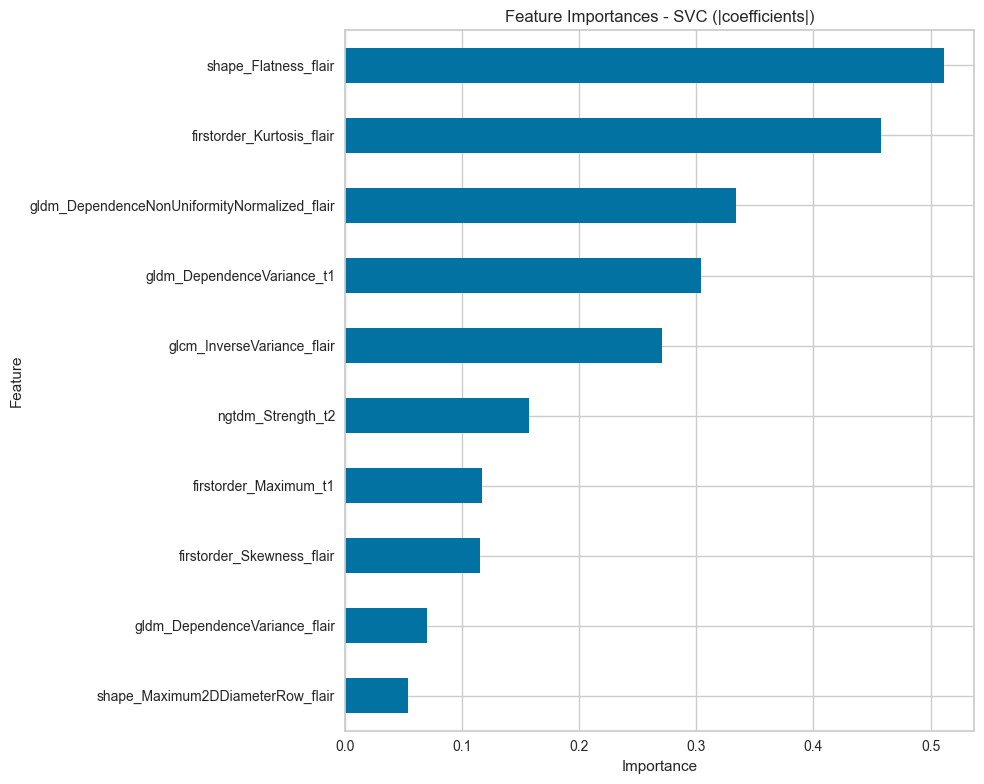

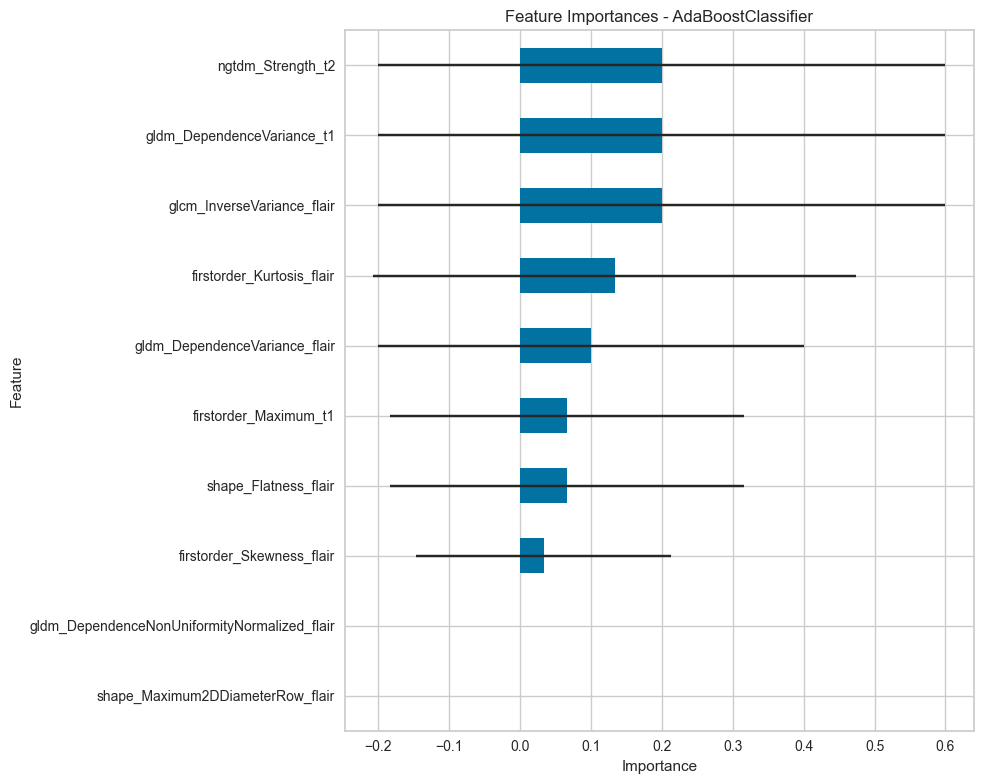

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def plot_feature_importance(
    model, 
    X, 
    y=None, 
    model_name=None, 
    feature_names=None, 
    n_repeats=20, 
    random_state=0
):
    """
    Plots feature importance for tree-based models (feature_importances_),
    linear models with coef_ (e.g., linear SVM), and falls back to
    permutation importance otherwise (requires y).
    """
    if model_name is None:
        model_name = type(model).__name__

    # Normalize inputs & feature names
    if hasattr(X, "columns"): #df
        X_array = X.values
        f_names = X.columns.tolist()
    else: #np array
        X_array = X
        if feature_names is not None:
            f_names = list(feature_names)
        else:
            f_names = [f"feature_{i}" for i in range(X_array.shape[1])]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Tree-based (e.g. AdaBoost)
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=f_names)
        imp_sorted = imp.sort_values(ascending=True)

        # std across base estimators if available; ignore if not applicable
        std_sorted = None
        if hasattr(model, "estimators_"):
            try:
                all_imps = []
                for est in model.estimators_:
                    if hasattr(est, "feature_importances_"):
                        all_imps.append(est.feature_importances_)
                if all_imps:
                    std = pd.Series(np.std(np.vstack(all_imps), axis=0), index=f_names)
                    std_sorted = std.loc[imp_sorted.index].values
            except Exception:
                std_sorted = None
    
        imp_sorted.plot.barh(xerr=std_sorted, ax=ax)
        ax.set_title(f"Feature Importances - {model_name}")

    # Linear models with coef_ (e.g., LinearSVC) 
    elif hasattr(model, "coef_"):
        coefs = model.coef_
        # Handle multi-class: take L2 norm across classes
        if coefs.ndim == 2:
            coefs = np.linalg.norm(coefs, axis=0)
        imp = pd.Series(np.abs(coefs), index=f_names)
        imp_sorted = imp.sort_values(ascending=True)
        imp_sorted.plot.barh(ax=ax)
        ax.set_title(f"Feature Importances - {model_name} (|coefficients|)")

    # Else do permutation importance (e.g., KNN, SVM-RBF)
    else:
        if y is None:
            raise ValueError("Permutation importance requires y. Please pass y.")
        print(f"Permutation importance for {model_name}")
        result = permutation_importance(
            model, 
            X_array, 
            y, 
            n_repeats=n_repeats, 
            random_state=random_state,
            n_jobs=-1
        )
        imp = pd.Series(result.importances_mean, index=f_names)
        std = pd.Series(result.importances_std, index=f_names)

        imp_sorted = imp.sort_values(ascending=True)
        std_sorted = std.loc[imp_sorted.index].values  # <-- align by feature name

        imp_sorted.plot.barh(xerr=std_sorted, ax=ax)
        ax.set_title(f"Permutation Importance - {model_name}")

    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    fig.tight_layout()

# convert scale transformed train back to df
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

plot_feature_importance(final_knn,  X_train_scaled_df, y_train)
plot_feature_importance(final_svm,  X_train_scaled_df, y_train)# RBF → permutation
plot_feature_importance(final_svml, X_train_scaled_df, y_train)# linear → coef_
plot_feature_importance(final_ada,  X_train_scaled_df, y_train)# trees → feature_importances_

#### Now generating figures and metrics to evaluate the performance of the extra trees classifier.

In [ ]:
# creating a feature importance plot
# feature importance plots are based on the mean decrease in impurity

def feat_importance(model, X_train):
    # get model name
    model_type = type(model)
    model_name = model_type.__name__

    if tree not in model.estimators_:
        print(f"invalid model:{model_name}")

    # getting importance values and feature names
    importances = model.feature_importances_
    features = X_train.columns

    # calculating standard deviation
    std_importances = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # sorting features for plotting
    indices = np.argsort(importances)[::-1]

    et_importances = pd.Series(importances, index=features)

    fig, ax = plt.subplots(figsize=(10,8))
    et_importances.sort_values(ascending=False).plot.bar(yerr=std_importances[et_importances.argsort()[::-1]], ax=ax)

    ax.set_title("Feature importances - Extra Trees Classifier")
    ax.set_ylabel("Mean decrease in impurity")
    ax.set_xlabel("Radiomics feature")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    fig.tight_layout()

    coefs = model.coef_[0]
    feature_names = X_train.columns

    importance_df = (
        pd.DataFrame({
            'feature': feature_names,
            'coef': coefs,
            'abs_coef': np.abs(coefs)
        })
        .sort_values('abs_coef', ascending=False)
    )

    print(importance_df.head(20))


plot_feature_importance

                                        feature      coef  abs_coef
0                          shape_Flatness_flair -0.511445  0.511445
2                     firstorder_Kurtosis_flair -0.457714  0.457714
6  gldm_DependenceNonUniformityNormalized_flair  0.333668  0.333668
8                    gldm_DependenceVariance_t1  0.304470  0.304470
5                    glcm_InverseVariance_flair -0.271208  0.271208
9                             ngtdm_Strength_t2  0.157231  0.157231
3                         firstorder_Maximum_t1 -0.116904  0.116904
4                     firstorder_Skewness_flair  0.115053  0.115053
7                 gldm_DependenceVariance_flair -0.070544  0.070544
1              shape_Maximum2DDiameterRow_flair  0.053972  0.053972
